# Qualcomm AI Engine Direct Model Execution on Android on Snapdragon

## Configure a Qualcomm Snapdragon Android device

In [1]:
!adb devices -l

List of devices attached
208bc00f               device usb:3-3 product:fuxi model:2211133C device:fuxi transport_id:2



## Prepare the binaries and libraries for execution

In [2]:
# Copy the required libraries and binaries to libs folder 
import shutil
import os

execution_ws = os.getcwd()
SDK_dir = "/opt/qcom/aistack/qairt/2.21.0.240401"
lib_dir = SDK_dir + "/lib/aarch64-android/"
binary = SDK_dir + "/bin/aarch64-android/qnn-net-run"
skel = SDK_dir + "/lib/hexagon-v73/unsigned/libQnnHtpV73Skel.so"
des_dir = execution_ws + "/tmp/"
if os.path.exists(des_dir):
    shutil.rmtree(des_dir)
if not os.path.exists(des_dir):
    os.mkdir(des_dir)
# Clear the destination directory.
target_device_dir = "/data/local/tmp/qnn_assets/QNN_binaries"
# This is the path of the prepared model binaries
models_context_path = 'assets/stable_diffusion/serialized_binaries'

for model_bin in os.listdir(models_context_path):
    shutil.copy(f'{models_context_path}/' + model_bin, des_dir)
# Copy necessary libraries to a common location
libs = ["libQnnHtp.so", "libQnnHtpNetRunExtensions.so", "libQnnHtpPrepare.so", "libQnnHtpV73Stub.so"]
for lib in libs:
    shutil.copy(lib_dir+lib, des_dir)
    
# Copy binary
shutil.copy(binary, des_dir)

# Copy Skel
shutil.copy(skel, des_dir)

'/home/zhenghaoz/PycharmProjects/notebooks/tmp/libQnnHtpV73Skel.so'

In [3]:
# Htp backend extensions config file (htp_backend_extensions.json) example
htp_backend_extensions_data = '''
{
    "backend_extensions": {
        "shared_library_path": "libQnnHtpNetRunExtensions.so",
        "config_file_path": "/tmp/htp_config.json"
    }
}
'''

# HTP backend config file (htp_config.json) example
htp_config_data = '''
{
    "graphs": {
        "vtcm_mb":8,
        "graph_names":["qnn_model"]
    },
    "devices": [
        {
            "soc_id": 30,
            "dsp_arch": "v73",
            "cores":[{
                "core_id": 0,
                "perf_profile": "burst",
                "rpc_control_latency":100
            }]
        }
    ]
}
'''
#write the config files to a temporary location
with open(des_dir + '/htp_backend_extensions.json','w') as f:
    f.write(htp_backend_extensions_data)
with open(des_dir + '/htp_config.json','w') as f:
    f.write(htp_config_data)

In [4]:
# Optional: remove target directory from the device if retrying these steps
!adb shell rm -rf $target_device_dir

## Push the prepared models and binaries on the device

In [5]:
!adb push $des_dir $target_device_dir

/home/zhenghaoz/PycharmProjects/notebo...7.6 MB/s (1154929285 bytes in 23.145s)


## User Inputs

In [6]:
import numpy as np

# Any user defined prompt
user_prompt = "decorated modern country house interior, 8 k, light reflections"
#user_prompt = "A small cute bunny, holding a smartphone,8k, unreal engine 5"

# User defined seed value
user_seed = np.int64(1.36477711e+14)

# User defined step value, any integer value in {20, 50}
user_step = 20

# User define text guidance, any float value in [5.0, 15.0]
user_text_guidance = 7.5

# Error checking for user_seed
assert isinstance(user_seed, np.int64) == True,"user_seed should be of type int64"

# Error checking for user_step
assert isinstance(user_step, int) == True,"user_step should be of type int"
assert user_step == 20 or user_step == 50,"user_step should be either 20 or 50"

# Error checking for user_text_guidance
assert isinstance(user_text_guidance, float) == True,"user_text_guidance should be of type float"
assert user_text_guidance >= 5.0 and user_text_guidance <= 15.0,"user_text_guidance should be a float from [5.0, 15.0]"

## Embedding Functions

In [7]:
import torch
from diffusers import UNet2DConditionModel
from diffusers.models.embeddings import get_timestep_embedding

# Pre-load time embedding
time_embeddings = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', 
                                                       subfolder='unet', 
                                                       cache_dir='./cache/diffusers',
                                                       proxies={'https': '127.0.0.1:7890'}).time_embedding

def get_time_embedding(timestep):
    timestep = torch.tensor([timestep])
    t_emb = get_timestep_embedding(timestep, 320, True, 0)
    emb = time_embeddings(t_emb).detach().numpy()
    return emb    

/home/zhenghaoz/PycharmProjects/notebooks/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Tokenizer

In [8]:
import numpy as np
from tokenizers import Tokenizer

%env TOKENIZERS_PARALLELISM=false

# Define Tokenizer output max length (must be 77)
tokenizer_max_length = 77

# Initialize the Tokenizer
tokenizer = Tokenizer.from_file("tokenizer.json")

# Set max length to tokenizer_max_length
tokenizer.enable_truncation(tokenizer_max_length)
tokenizer.enable_padding(pad_id=49407, length=tokenizer_max_length)

def run_tokenizer(prompt):
    # Run Tokenizer encoding
    token_ids = tokenizer.encode(prompt).ids
    # Convert tokens list to np.array
    token_ids = np.array(token_ids, dtype=np.float32)

    return token_ids

env: TOKENIZERS_PARALLELISM=false


## Scheduler functions

In [9]:
import numpy as np
import torch
from diffusers import DPMSolverMultistepScheduler

# Initializing the Scheduler
scheduler = DPMSolverMultistepScheduler(num_train_timesteps=1000, beta_start=0.00085,
                                        beta_end=0.012, beta_schedule="scaled_linear")
# Setting up user provided time steps for Scheduler
scheduler.set_timesteps(user_step)

def run_scheduler(noise_pred_uncond, noise_pred_text, latent_in, timestep):
    # Convert all inputs from NHWC to NCHW
    noise_pred_uncond = np.transpose(noise_pred_uncond, (0,3,1,2)).copy()
    noise_pred_text = np.transpose(noise_pred_text, (0,3,1,2)).copy()
    latent_in = np.transpose(latent_in, (0,3,1,2)).copy()

    # Convert all inputs to torch tensors
    noise_pred_uncond = torch.from_numpy(noise_pred_uncond)
    noise_pred_text = torch.from_numpy(noise_pred_text)
    latent_in = torch.from_numpy(latent_in)

    # Merge noise_pred_uncond and noise_pred_text based on user_text_guidance
    noise_pred = noise_pred_uncond + user_text_guidance * (noise_pred_text - noise_pred_uncond)

    # Run Scheduler step
    latent_out = scheduler.step(noise_pred, timestep, latent_in)['prev_sample'].numpy()
    
    # Convert latent_out from NCHW to NHWC
    latent_out = np.transpose(latent_out, (0,2,3,1)).copy()
    
    return latent_out

# Function to get timesteps
def get_timestep(step):
    return np.int32(scheduler.timesteps.numpy()[step])

## Inference using Qualcomm AI Engine Direct

In [10]:
import numpy as np
import os
import shutil 

# Define QNN binaries path
QNN_binaries_path = des_dir

# Define generic qnn-net-run block
def run_qnn_net_run(model_context, input_data_list, remote_host='', device_id=''):
    # Define tmp directory path for intermediate artifacts
    tmp_dirpath = os.path.abspath('tmp/inputs')
    os.makedirs(tmp_dirpath, exist_ok=True)
    
    # Dump each input data from input_data_list as raw file
    # and prepare input_list_filepath for qnn-net-run
    input_list_text = ''
    for index, input_data in enumerate(input_data_list):
        # Create and dump each input into raw file
        raw_file_path = f'{tmp_dirpath}/input_{index}.raw'
        input_data.tofile(raw_file_path)
        # Keep appending raw_file_path into input_list_text for input_list_filepath file
        input_list_text += target_device_dir + '/inputs/' + os.path.basename(raw_file_path) + ' '
    # Create input_list_filepath and add prepared input_list_text into this file
    input_list_filepath = f'{tmp_dirpath}/../input_list.txt'
    with open(input_list_filepath, 'w') as f:
        f.write(input_list_text)
    !adb push $input_list_filepath $target_device_dir > /dev/null
    !adb push $tmp_dirpath $target_device_dir > /dev/null
    # Execute qnn-net-run on shell
    !adb shell sh -c "export LD_LIBRARY_PATH=$target_device_dir && export ADSP_LIBRARY_PATH=$target_device_dir && $target_device_dir/qnn-net-run --retrieve_context $model_context --backend $target_device_dir/libQnnHtp.so --input_list $target_device_dir/input_list.txt --output_dir $target_device_dir --config_file $target_device_dir/htp_config.json" > $tmp_dirpath/log.txt
    #pull the output file from the device
    !adb pull $target_device_dir/Result_0/output_1.raw $tmp_dirpath > /dev/null
    # Read the output data generated by qnn-net-run
    output_data = np.fromfile(f'{tmp_dirpath}/output_1.raw', dtype=np.float32)
    # Delete all intermediate artifacts
    shutil.rmtree(tmp_dirpath)
    
    return output_data


# qnn-net-run for text encoder
def run_text_encoder(input_data, rh='',device=''):
    output_data = run_qnn_net_run(f'{target_device_dir}/text_encoder.serialized.bin', [input_data],rh, device)
    # Output of Text encoder should be of shape (1, 77, 768)
    output_data = output_data.reshape((1, 77, 768))
    return output_data

# qnn-net-run for U-Net
def run_unet(input_data_1, input_data_2, input_data_3, rh='', device=''):
    output_data = run_qnn_net_run(f'{target_device_dir}/unet.serialized.bin', [input_data_1, input_data_2, input_data_3],rh,device)
    # Output of UNet should be of shape (1, 64, 64, 4)
    output_data = output_data.reshape((1, 64, 64, 4))
    return output_data

# qnn-net-run for VAE
def run_vae(input_data, rh='', device=''):
    output_data = run_qnn_net_run(f'{target_device_dir}/vae_decoder.serialized.bin', [input_data],rh,device)
    # Convert floating point output into 8 bits RGB image
    output_data = np.clip(output_data*255.0, 0.0, 255.0).astype(np.uint8)
    # Output of VAE should be of shape (512, 512, 3)
    output_data = output_data.reshape((512, 512, 3))
    return output_data

## Execute the Stable Diffusion pipeline

In [11]:
import tqdm
import warnings
warnings.filterwarnings('ignore')

# Run Tokenizer
uncond_tokens = run_tokenizer("")
cond_tokens = run_tokenizer(user_prompt)
# Run Text Encoder on Tokens
uncond_text_embedding = run_text_encoder(uncond_tokens)
user_text_embedding = run_text_encoder(cond_tokens)
# Initialize the latent input with random initial latent
random_init_latent = torch.randn((1, 4, 64, 64), generator=torch.manual_seed(user_seed)).numpy()
latent_in = random_init_latent.transpose((0, 2, 3, 1)).copy()

# Run the loop for user_step times
for step in tqdm.tqdm(range(user_step)):
    #print(f'Step {step} Running...')
    
    # Get timestep from step
    timestep = get_timestep(step)

    # Run U-net for const embeddings
    unconditional_noise_pred = run_unet(latent_in, get_time_embedding(timestep), uncond_text_embedding)

    # Run U-net for user text embeddings
    conditional_noise_pred = run_unet(latent_in, get_time_embedding(timestep), user_text_embedding)
    
    # Run Scheduler
    latent_in = run_scheduler(unconditional_noise_pred, conditional_noise_pred, latent_in, timestep)

# Run VAE
output_image = run_vae(latent_in)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  4.96s/it]


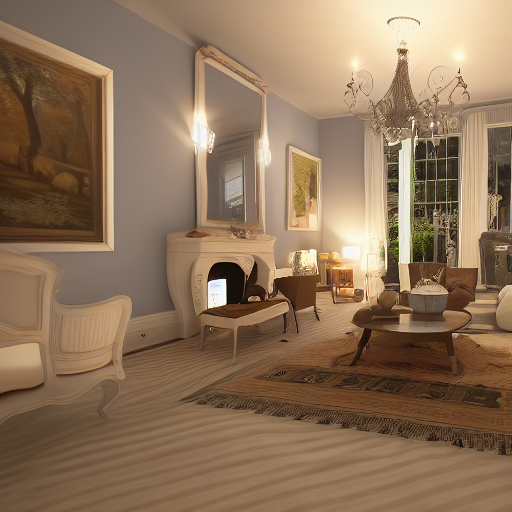

In [12]:
from PIL import Image
from IPython.display import display

# Display the generated output
display(Image.fromarray(output_image, mode="RGB"))